In [11]:
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np
from matplotlib import pyplot as plt
import qiskit.quantum_info as qi
from qiskit.visualization import plot_bloch_multivector
from scipy.linalg import sqrtm

In [12]:
def u_thetas(thetas, qc):
    """Create U_thetas sub circuit

    Args:
        thetas (numpy array): Param for Rz, Rx, Rz
        qc (QuantumCircuit): current circuit

    Returns:
        QuantumCircuit: added circuit
    """
    qc.rz(thetas[0], 0)
    qc.rx(thetas[1], 0)
    qc.rz(thetas[2], 0)
    return qc
    
def get_psi_hat(thetas):
    a = np.exp(-1j/2*(thetas[0]+thetas[2]))*np.cos(thetas[1]/2)
    b = (1j*np.cos((thetas[0]+thetas[2])/2) + np.sin((thetas[0]+thetas[2])/2))*np.sin(thetas[1]/2)
    return np.array([a, b])
    

def u_3():
    qc = QuantumCircuit(1, 1)
    qc.u3(theta, phi, lambdaz, 0)
    return qc
def construct_circuit(thetas):
    """Return one-qubit quantum circuit as instructions

    Args:
        thetas (np array): Params for U_theta gate

    Returns:
        QuantumCircuit
    """
    qc = u_3()
    qc = u_thetas(thetas, qc)
    qc.measure(0, 0)
    return qc
def measure(qc):
    """Get P0 values by measurement
    Args:
        qc (QuantumCircuit)
    Returns:
        float: P0
    """
    qobj = assemble(qc, shots = number_of_shot)  
    counts = sim.run(qobj).result().get_counts()
    return counts['0'] / number_of_shot
def grad(thetas1, thetas2):
    qc1 = construct_circuit(thetas1)
    qc2 = construct_circuit(thetas2)
    return -1/2*(measure(qc1) - measure(qc2))

def grad_l(thetas):
    gradient_l = np.zeros(len(thetas))
    for i in range(0, len(thetas)):
        thetas1, thetas2 = thetas.copy(), thetas.copy()
        thetas1[i] += np.pi/2
        thetas2[i] -= np.pi/2
        gradient_l[i] = grad(thetas1, thetas2)
    return gradient_l

Step 0: 0.9137
Step 10: 0.8135
Step 20: 0.6255
Step 30: 0.37239999999999995
Step 40: 0.1855
Step 50: 0.06889999999999996
Step 60: 0.02749999999999997
Step 70: 0.010800000000000032
Step 80: 0.0033999999999999586
Step 90: 0.0020999999999999908
Step 100: 0.0006000000000000449
Step 110: 0.00019999999999997797
Step 120: 9.999999999998899e-05
Step 130: 9.999999999998899e-05
Step 140: 9.999999999998899e-05
     ┌─────────────────────┐┌──────────────┐┌────────────┐┌───────────────┐┌─┐
q_0: ┤ U3(2.5727,1.9069,0) ├┤ RZ(-0.31433) ├┤ RX(2.5689) ├┤ RZ(-0.001465) ├┤M├
     └─────────────────────┘└──────────────┘└────────────┘└───────────────┘└╥┘
c: 1/═══════════════════════════════════════════════════════════════════════╩═
                                                                            0 
Statevector([ 0.28060655+0.j        , -0.31656665+0.90611562j],
            dims=(2,))
DensityMatrix([[ 0.07874004+0.j        , -0.08883068-0.25426198j],
               [-0.08883068+0.25426198j,  0.9212

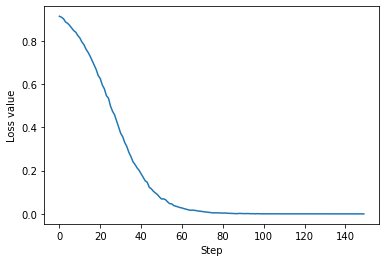

In [13]:
# Theta, phi, lambdaz is the params of u3 gate
theta = np.random.uniform(0, np.pi)
phi = np.random.uniform(0, 2*np.pi)
lambdaz = 0
# Thetas is the param of rz, rx, rz gates
thetas = np.zeros([3,])
sim = Aer.get_backend('qasm_simulator')
number_of_shot = 10000
learning_rate = 0.1
# Calculate loss function in 100 steps
# I confused in this point, is below code right?
ls = []
for i in range(0, 150):
    thetas = thetas - learning_rate*grad_l(thetas)
    qc = construct_circuit(thetas)
    l = 1 - measure(qc)
    ls.append(l)
    if i % 10 == 0:
        print('Step ' + str(i) + ': ' + str(l) )

print(qc.draw())
psi = qi.Statevector.from_instruction(u_3())
psi_hat = qi.Statevector(get_psi_hat(thetas))
rho_psi = qi.DensityMatrix(psi)
rho_psi_hat = qi.DensityMatrix(psi_hat)

print(psi)
print(rho_psi)
print(psi_hat)
print(rho_psi_hat)

plt.show()
plt.plot(ls)
plt.xlabel("Step")
plt.ylabel("Loss value")
plt.show()
    

In [18]:
def trace_distance(rho_psi, rho_psi_hat):
    """Since density matrices are Hermitian,
    so trace distance is 1/2 (Sigma(|lambdas|)) with lambdas are the eigenvalues of 
    (rho_psi - rho_psi_hat) matrix

    Args:
        rho_psi (DensityMatrix): psi,
        rho_psi_hat (DensityMatrix): psi hat
    """
    w, v = np.linalg.eig((rho_psi - rho_psi_hat).data)
    return (1/2*sum(abs(w)))


def trace_fidelity(rho_psi, rho_psi_hat):
    rho_psi = rho_psi.data
    rho_psi_hat = rho_psi_hat.data
    return np.trace(sqrtm((sqrtm(rho_psi)).dot(rho_psi_hat)).dot(sqrtm(rho_psi)))


print(psi.data)
print(psi_hat.data)

print(trace_distance(rho_psi, rho_psi_hat))
# I get real part because the imaginary part ~ 0
print(np.real(trace_fidelity(rho_psi, rho_psi_hat)))
print(((psi_hat.conjugate()).data.transpose()).dot(psi.data))


[ 0.28060655+0.j         -0.31656665+0.90611562j]
[ 0.27893083+0.04441218j -0.15083988+0.94735024j]
0.09038949260913187
0.9959064913916605
(0.9844295470415626+0.15075876935491264j)
